# Анализ бизнес-показателей Яндекс.Афиши

Проект включает в себя:

- Анализ продукта

- Анализ продаж

- Анализ маркетинга

Расчет ключевых бизнес-показателей (DAU, WAU, MAU, Retention Rate, LTV, ROMI) в зависимости от устройства входа и рекламного источника

In [1]:
# Импортируем необходимые для выполнения проекта библиотеки
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
pd.options.mode.chained_assignment = None

## Загрузка и знакомство с данными

In [2]:
visits = pd.read_csv('Путь к датасету') 
orders = pd.read_csv('Путь к датасету')
costs = pd.read_csv('Путь к датасету')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<div class="alert alert-block alert-info">
Таблица с информацией о посещении сайта

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь   
</div>

In [4]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<div class="alert alert-block alert-info">
Таблица с информацией о заказах

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа   
</div>

In [5]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<div class="alert alert-block alert-info">
Таблица с информацией о заказах на маркетинг

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день
</div>

## Предобработка данных

1. Проверка на пропуска;
2. Проверка на типы данных;
3. Проверка имен столбцов;
4. Проверка на дубликаты; 
5. Проверка дат на соответствие условию

In [6]:
# функция для проверки и переименования стобцов
def check(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    print('Дубликатов:', df.duplicated().sum())
    df.info()

In [7]:
# Проверим наши датафреймы
for df in [visits, orders, costs]:
    check(df)
    print('------------------------------------------------------')
    print('------------------------------------------------------')

Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   start_ts   359400 non-null  object
 4   uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
------------------------------------------------------
------------------------------------------------------
Дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   buy_ts   50415 non-null  object 
 1   revenue  50415 non-null  float64
 2   uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
-------------------------------------------------

<div class="alert alert-block alert-info">
Пропусков и дубликатов в данных нет.
    
Перед началом работы необходимо привести столбцы с датами к нужному типу.
    
Затем проверить даты на соответствие наших условий
</div>

In [8]:
# Приведем столбцы к типу datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
visits[['end_ts', 'start_ts']].describe().T

,count,unique,top,freq,first,last
end_ts,359400,224760,2017-11-24 16:51:00,23,2017-06-01 00:02:00,2018-06-01 01:26:00
start_ts,359400,224303,2017-11-24 16:06:00,19,2017-06-01 00:01:00,2018-05-31 23:59:00


In [10]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [11]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

<div class="alert alert-block alert-info">
Обратим внимание, что в датафрейме orders есть данные от июня 2018 года, а должны быть только по май этого года. Необходимо срезать данные, чтобы у нас не сформировалась ненужная когорта.
    </div>

In [12]:
orders = orders.query('buy_ts < "2018-06-01"')
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

### Итоги предобработки данных

Данные проверены на пропуски и дубликаты, столбцы переименованы, даты приведены к нужному типу данных


## Анализ продукта

1) Сколько людей пользуются в день, неделю, месяц?

- Посчитать общий DAU, WAU, MAU. Значения метрик в зависимости от устройств и источников рекламы отобразить на графиках

2) Сколько сессий в среднем совершает один пользователь в день?

- Посчитать для ПК и телефона, сравнить

3) Сколько длится одна сессия?

- Посчитать для ПК и телефона, сравнить

4)  Как часто люди возвращаются?

- Retention Rate посчитаем для пользователей ПК и телефонов в отдельности

In [13]:
# Выделим из даты посещения день, неделю и месяц
visits = visits.assign(
day = lambda x: x['start_ts'].dt.date,
week = lambda x: x['start_ts'].astype('datetime64[W]'),
month = lambda x: x['start_ts'].astype('datetime64[M]')
)

# Найдем DAU, WAU и MAU 
dau = visits.groupby('day').agg({'uid':'nunique'}).mean().round()
wau = visits.groupby('week').agg({'uid':'nunique'}).mean().round()
mau = visits.groupby('month').agg({'uid':'nunique'}).mean().round()

# Выведем на экран
print('Среднее количество пользователей в день:', int(dau))
print('Среднее количество пользователей в неделю:', int(wau))
print('Среднее количество пользователей в месяц:', int(mau))

Среднее количество пользователей в день: 908
Среднее количество пользователей в неделю: 5724
Среднее количество пользователей в месяц: 23228


<div class="alert alert-block alert-info">
Построим графики метри в зависимости от используемого устройства и от источника рекламы
    </div>

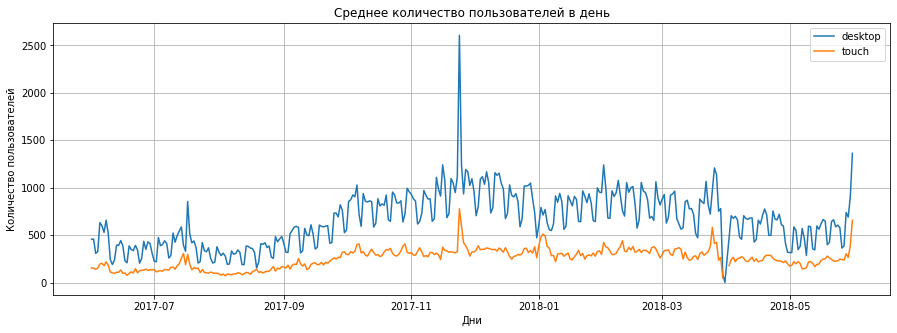

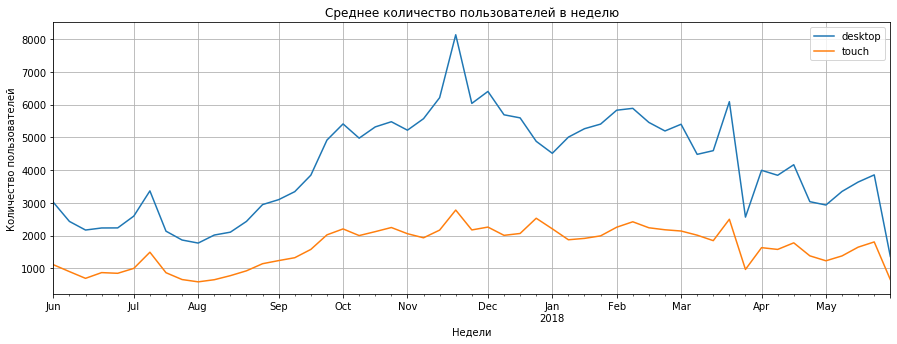

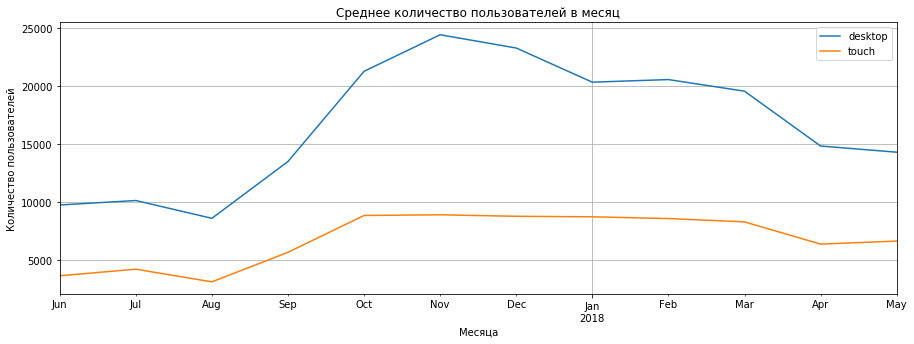

In [14]:
# Создадим словарь для построения графиков
dict_for_plot = {'day': ['Дни', 'Среднее количество пользователей в день'],
                 'week': ['Недели', 'Среднее количество пользователей в неделю'],
                'month': ['Месяца', 'Среднее количество пользователей в месяц']}


# Построим цикл для отображения графиков по параметрам
for column in dict_for_plot.keys():
    pivot_devices = visits.pivot_table(index = column, columns = 'device', values = 'uid', aggfunc = 'nunique')\
    .plot(figsize = (15,5), title = dict_for_plot[column][1], grid = True)
    plt.ylabel('Количество пользователей')
    plt.xlabel(dict_for_plot[column][0])
    plt.legend()
    plt.show()


<div class="alert alert-block alert-info">
Яндекс.Афишей значительно больше используют пользователи ПК. Количество посетителей растет ближе к зиме и уменьшается к теплым периодам. Весна и лето - сезоны отпусков, а зимой больше людей дома, соответсвенно чаще планируют свой культурный досуг
    </div>

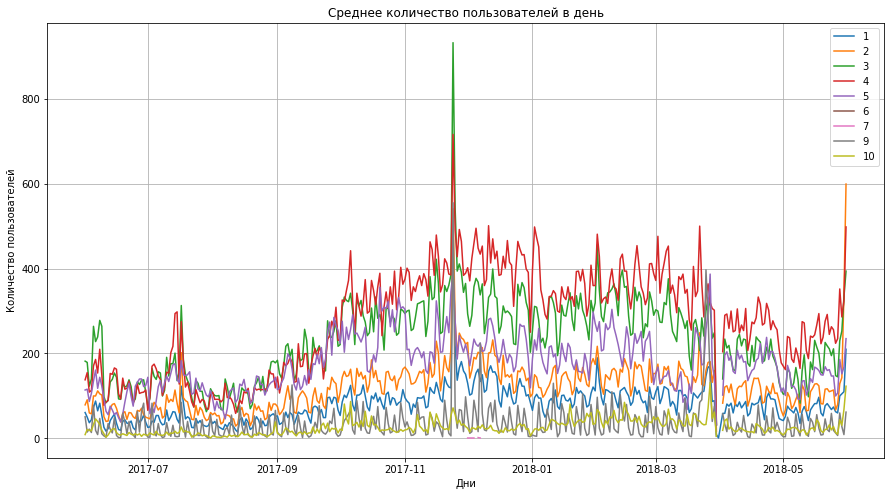

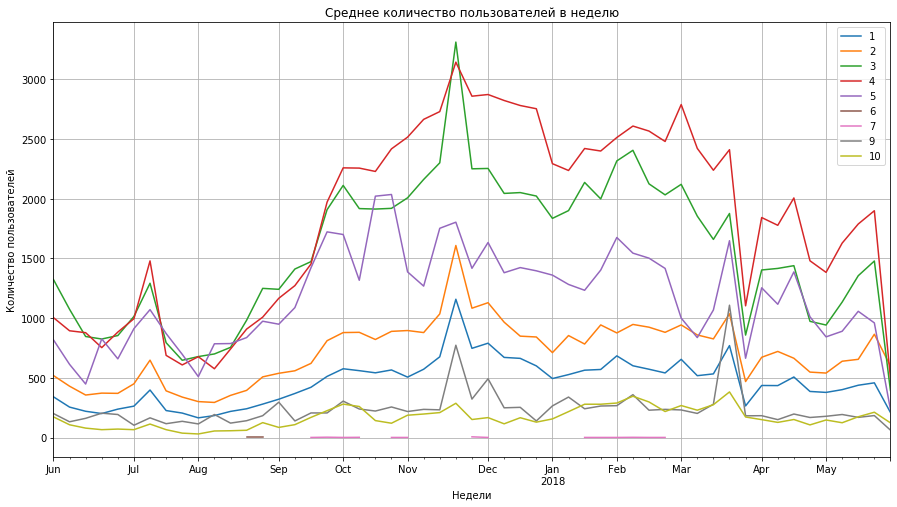

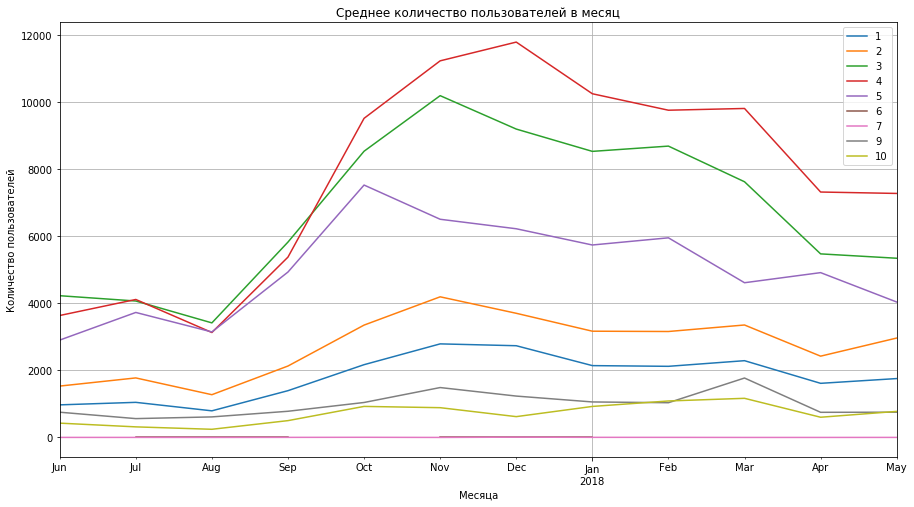

In [15]:
for column in dict_for_plot.keys():
    pivot_source_id = visits.pivot_table(index = column, columns = 'source_id', values = 'uid', aggfunc = 'nunique')\
    .plot(figsize = (15,8), title = dict_for_plot[column][1], grid = True)
    plt.ylabel('Количество пользователей')
    plt.xlabel(dict_for_plot[column][0])
    plt.legend()
    plt.show()

<div class="alert alert-block alert-info">
Самое большое число пользователей нам приносят 4, 3 и 5 источники рекламы. Кривые количества пользователей и количества пользователей в зависимости от рекламы выглядят одинаково, из чего следует, что все рекламные источники у нас работают на протяжении года и привлекают пользователей на ресурс.

6 и 7 источники рекламы на нуле, надо проверить, сколько пользователей пришло из них
    </div>

In [16]:
visits.groupby('source_id').agg({'uid':'nunique'}).T

source_id,1,2,3,4,5,6,7,9,10
uid,18999,26245,74756,83525,56974,6,34,9264,8067


<div class="alert alert-block alert-info">
Всего 6 и 34 пользователя, для дальнейших расчетов надо срезать эти данные из таблицы visits
    </div>

In [17]:
visits = visits.query('source_id != 6 and source_id != 7')

<div class="alert alert-block alert-info">
Посчитаем среднее количество пользователей разных устройств в зависимости от источников рекламы. Совпадет ли она с общим средним количеством или пользователи ПК и телефонов опираются на разные рекламны источники. Построим графики по месяцам.
    </div>

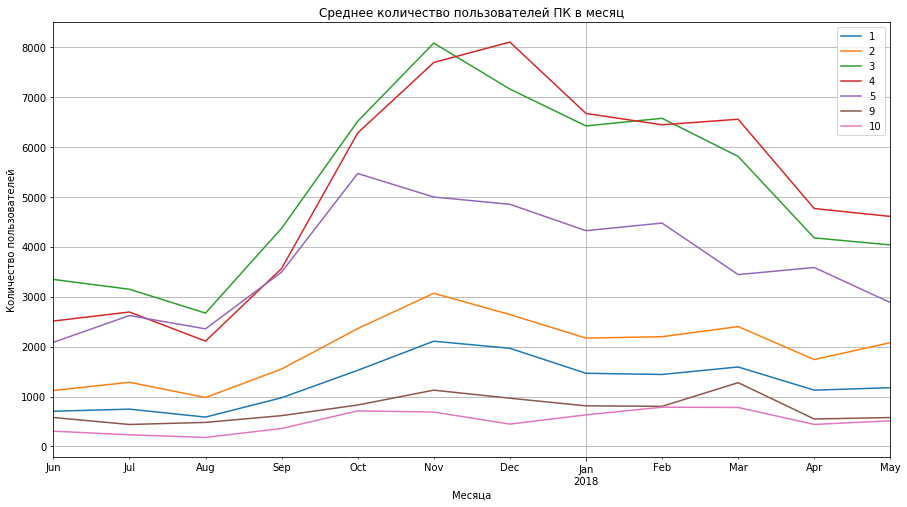

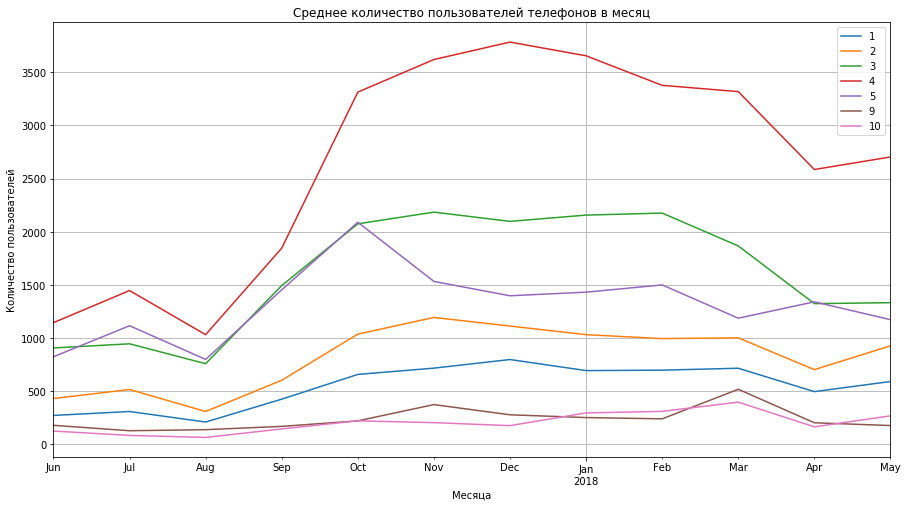

In [18]:
dict_for_plot_devices = {'desktop': ['Месяца', 'Среднее количество пользователей ПК в месяц'],
                        'touch': ['Месяца', 'Среднее количество пользователей телефонов в месяц']}

for column in dict_for_plot_devices.keys():
    pivot_source_devices = visits[visits['device'] == column]\
    .pivot_table(index = 'month', columns = 'source_id', values = 'uid', aggfunc = 'nunique')\
    .plot(figsize = (15,8), title = dict_for_plot_devices[column][1], grid = True)
    plt.ylabel('Количество пользователей')
    plt.xlabel(dict_for_plot_devices[column][0])
    plt.legend()
    plt.show()

<div class="alert alert-block alert-info">
Пользователи телефонов гораздо меньше используют рекламу из источника 3, необходимо проверить, может она не поступает или некорректно отображается на некоторых моделях по техническим причинам. А может браузеры некоторых телефонов блокируют рекламу из этого источника.
    </div>

In [19]:
# Посчитаем сколько сессий в день и среднее число сессий на одного пользователя
sessions = visits.groupby('day').agg({'uid':'count'}).mean().round()
print('Среднее количество сессий в день:', int(sessions))
print('Среднее количество сессий одного пользователя в день:', round(int(sessions)/int(dau), 2))

Среднее количество сессий в день: 987
Среднее количество сессий одного пользователя в день: 1.09


<div class="alert alert-block alert-info">
Такое значения среднего избавляет нас от необходимости считать его отдельно для ПК и телефона. Меньше одной сессии быть не может

Как правило пользователи не заходят на Яндекс.Афишу больше одного раза в день. Одного сеанса достаточно для планирования культурного досуга.
    </div>

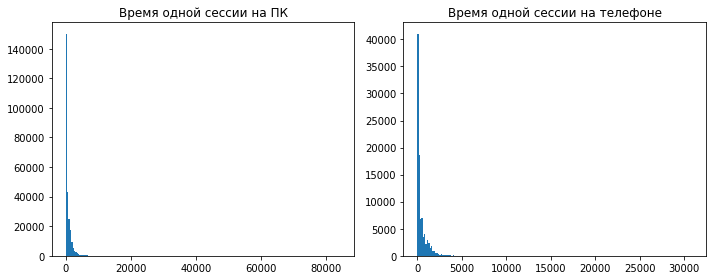

In [20]:
# Посчитаем время одной сессии и посмотрим на распределение данных по устройствам
visits['session_time'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 4)
ax[0].hist(visits.query('device == "desktop"')['session_time'], bins = 200)
ax[0].set_title('Время одной сессии на ПК')
ax[1].hist(visits.query('device == "touch"')['session_time'], bins = 200)
ax[1].set_title('Время одной сессии на телефоне')
plt.tight_layout()


<div class="alert alert-block alert-info">
Для подсчета средней сессии используем сразу три метрики: среднее, медиану, моду и выберем из них наиболее подходящую.
    </div>

In [21]:
print('Среднее компьютерной сессии:', int(visits.query('device == "desktop"')['session_time'].mean()), 'секунд')
print('Среднее телефонной сессии:', int(visits.query('device == "touch"')['session_time'].mean()), 'секунд')
print('---------------------------------------')
print('Медиана компьютерной сессии:', int(visits.query('device == "desktop"')['session_time'].median()), 'секунд')
print('Медиана телефонной сессии:', int(visits.query('device == "touch"')['session_time'].median()), 'секунд')
print('---------------------------------------')
print('Мода компьютерной сессии:', int(visits.query('device == "desktop"')['session_time'].mode()), 'секунд')
print('Мода телефонной сессии:', int(visits.query('device == "touch"')['session_time'].mode()), 'секунд')

Среднее компьютерной сессии: 703 секунд
Среднее телефонной сессии: 479 секунд
---------------------------------------
Медиана компьютерной сессии: 360 секунд
Медиана телефонной сессии: 180 секунд
---------------------------------------
Мода компьютерной сессии: 60 секунд
Мода телефонной сессии: 60 секунд


<div class="alert alert-block alert-info">
Среднее компьютерной сессии в полтора раза больше телефонной, а медиана - в два раза. Это можно было предположить, посмотрев на диаграммы распределения, значения по оси X для компьютерных сессий превышают телефонные. А вот моды у нас одинаковые. 

Очевидно распределение наших данных далеко от нормального, для подсчета метрики средней сессии будем использовать моду. В среднем пользователь и компьютера, и телефона проводит на сайте 60 секунд
    </div>

<div class="alert alert-block alert-info">
Рассчитаем коэффициент Retention Rate, для этого поделим наших пользователей на когорты по месяцам
    </div>

In [22]:
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,0


In [23]:
# Для каждого пользователя найдем месяц первого посещения
first_month = visits.groupby(['uid', 'device']).agg(first_month = ('month','min')).reset_index()

# Объединим таблицы по столбцам 
visits_cohorts = pd.merge(visits, first_month, on = ['uid', 'device'])

# Посчитаем лайфтайм
visits_cohorts['cohort_lifetime'] = ((visits_cohorts['month'] - visits_cohorts['first_month'])\
                                     / np.timedelta64(1,'M')).round().astype(int)
# Посмотрим на таблицу
visits_cohorts.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,session_time,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-01,0


In [24]:
# Посчитаем количество уникальных пользователей каждой когорты на каждом месяце жизни
user_cohorts = visits_cohorts.groupby(['device', 'first_month', 'cohort_lifetime'])\
.agg({'uid':'nunique'}).reset_index()
user_cohorts.head()

,device,first_month,cohort_lifetime,uid
0,desktop,2017-06-01,0,9760
1,desktop,2017-06-01,1,771
2,desktop,2017-06-01,2,541
3,desktop,2017-06-01,3,620
4,desktop,2017-06-01,4,678


In [25]:
# Найдем количество пользователей нулевых когорт

first_users = visits_cohorts.groupby(['device', 'first_month']).agg(cohort_users = ('uid','nunique')).reset_index()

# Объединим таблицы по первому месяцу 
cohorts = pd.merge(user_cohorts, first_users, on = ['device','first_month'])

# Посчитаем retention
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

# Посмотрим на таблицу
cohorts.head()

,device,first_month,cohort_lifetime,uid,cohort_users,retention
0,desktop,2017-06-01,0,9760,9760,1.000000
1,desktop,2017-06-01,1,771,9760,0.078996
2,desktop,2017-06-01,2,541,9760,0.055430
3,desktop,2017-06-01,3,620,9760,0.063525
4,desktop,2017-06-01,4,678,9760,0.069467


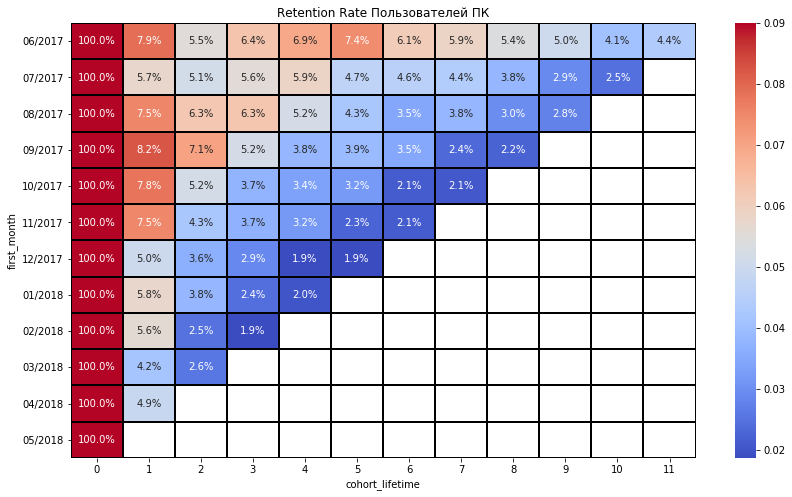

In [83]:
# Построим сводную таблицу
rr_table_desktop = cohorts.query('device == "desktop"')\
.pivot_table(index = 'first_month', columns = 'cohort_lifetime', values = 'retention')

# Приведем индексы к удобному отображению на тепловой карте
rr_table_desktop.index = rr_table_desktop.index.strftime("%m/%Y")

# Построим тепловую карту
plt.figure(figsize=(14, 8))
plt.title('Retention Rate Пользователей ПК')
sns.heatmap(rr_table_desktop, annot = True, fmt='.1%', linewidths=1, linecolor='black', vmax=0.09, cmap= 'coolwarm');

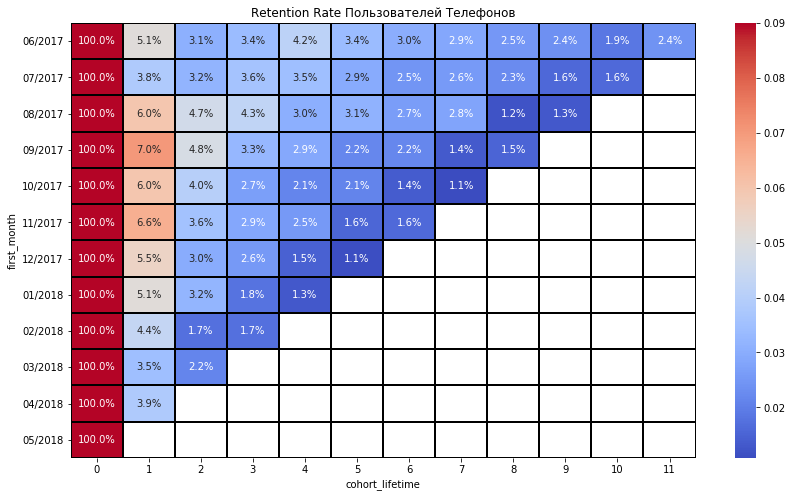

In [27]:
# Построим сводную таблицу
rr_table_touch = cohorts.query('device == "touch"')\
.pivot_table(index = 'first_month', columns = 'cohort_lifetime', values = 'retention')

# Приведем индексы к удобному отображению на тепловой карте
rr_table_touch.index = rr_table_touch.index.strftime("%m/%Y")

# Построим тепловую карту
plt.figure(figsize=(14, 8))
plt.title('Retention Rate Пользователей Телефонов')
sns.heatmap(rr_table_touch, annot = True, fmt='.1%', linewidths=1, linecolor='black', vmax=0.09, cmap= 'coolwarm');

<div class="alert alert-block alert-info">

Пользователи телефонов возвращаются гораздо реже пользователей ПК, нужно подумать над улучшением мобильной версии сайта
    </div>

### Итоги анализа продукта
1. Яндекс.Афишу, по большей части, используют пользователи ПК. 

2. В зимнее время ресурс популярнее, чем в летнее.

3. У пользователей ПК 2 самых популярных источника рекламы, а у телефонных пользователей - 1. Надо разобраться, возможно это техническая проблема на некоторых моделях телефона (или некоторых версиях телефонных браузеров)

4. Как правило, на одного пользователя приходится одна сессия в день, одного сеанса достаточно для планирования культурного досуга

5. Время средней сессии на ПК и телефоне у нас совпадает - 60 секунд.

6. Пользователи телефонов возвращаются гораздо реже пользователей ПК, нужно подумать над улучшением мобильной версии сайта.


## Анализ продаж

1) Когда люди начинают покупать?

- Посчитаем эту метрику, как в какую по счету сессию пользователи начинают покупать

2) Сколько раз покупают за период?

- Для вычисления этой метрики возьмем период в шесть месяцев, как наиболее оптимальный. До шести месяцев у нас доживает семь когорт. Если взять больше, то сократится число когорт, а меньше, на мой взгляд, слишком маленький период, чтобы судить о том, сколько покупок совершает каждый пользователь.


3) Какой средний чек?

- Суммарная выручка на количество покупок. Посчитаем средний чек в каждом месяце и посмотрим меняется ли в зависимости от устройства

4) Сколько денег приносят? (LTV)

- Посчиатем общий LTV за шесть месяцев и отдельно LTV для каждого источника рекламы.

<div class="alert alert-block alert-info">
Еще раз взглянем на наши таблицы
    </div>

In [28]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [29]:
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,session_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,0


In [30]:
# Посчитаем номер сессии каждого пользователя
visits['num_of_session'] = visits.sort_values(['uid','start_ts'], ascending=[True,True]) \
.groupby(['uid']).cumcount() + 1



# Объединим с таблицей с заказами
orders_with_visits = pd.merge(orders, visits, on = 'uid', how = 'left')

# Сделаем срез, чтобы время покупки находилось между началом и концом сессии
orders_with_visits = orders_with_visits.query('buy_ts >= start_ts and buy_ts <= end_ts')

orders_with_visits['num_of_session'] = orders_with_visits['num_of_session'].astype(int)

# Посмотрим на таблицу
orders_with_visits.head()

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,day,week,month,session_time,num_of_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1.0,2017-06-01 00:09:00,2017-06-01,2017-06-01,2017-06-01,120.0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2.0,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01,660.0,1
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2.0,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01,540.0,1
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2.0,2017-06-01 00:14:00,2017-06-01,2017-06-01,2017-06-01,1140.0,1
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3.0,2017-06-01 07:31:00,2017-06-01,2017-06-01,2017-06-01,1680.0,1


<div class="alert alert-block alert-info">
У нас может быть несколько заказов у одного пользователя, сгруппируем данные, найдем сессию первого заказа и посмотрим на распределение данных на столбчатой диаграмме
    </div>

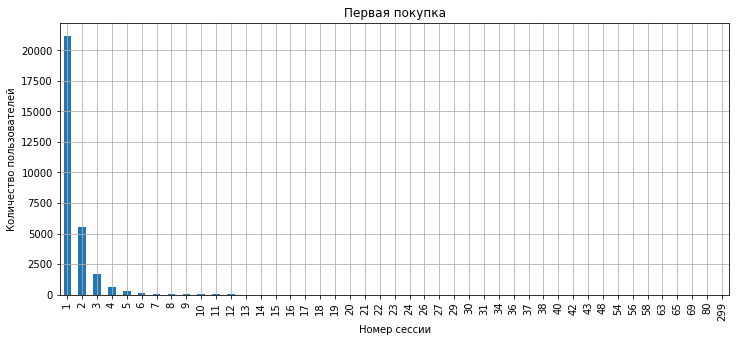

In [31]:
first_session = orders_with_visits.groupby('uid').agg({'num_of_session':'min'}).reset_index()


first_sessin_pivot = first_session.pivot_table(index = 'num_of_session', values = 'uid', aggfunc = 'count')
first_sessin_pivot.plot(kind = 'bar', figsize=(12, 5), legend = False, grid = True)
plt.ylabel('Количество пользователей')
plt.xlabel('Номер сессии')
plt.title('Первая покупка')
plt.show()

<div class="alert alert-block alert-info">
Видя такое распределение данных можно с уверенностью сказать, что в среднем совершают покупку при первом же посещении сайта. Большинство пользователей уже с первого раза заходят на сайт с конкретной целью - купить билет
    </div>

<div class="alert alert-block alert-info">
Посчитаем сколько пользователи совершают покупок за определенный период - 6 месяцев
    </div>

In [32]:
# Выделим месяц первой покупки
orders['month'] = orders['buy_ts'].astype('datetime64[M]')
# Сформируем когорты
orders_cohorts = orders.groupby('uid').agg(first_order_month = ('month', 'min')).reset_index()
orders_cohorts.head()

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [33]:
# Добавим к таблице первый месяц покупки
orders_for_purchase = pd.merge(orders, orders_cohorts, on = 'uid', how = 'left')
orders_for_purchase.head()

,buy_ts,revenue,uid,month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [34]:
# Рассчитаем время жизни когорты
orders_for_purchase['lifetime'] = ((orders_for_purchase['month'] - orders_for_purchase['first_order_month'])\
/ np.timedelta64(1,'M')).round().astype(int)
orders_for_purchase.head()

,buy_ts,revenue,uid,month,first_order_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0


In [84]:
# Посчитаем размер когорт и количество покупок на каждом месяце жизни когорты
cohort_size = orders_for_purchase.groupby('first_order_month')\
.agg(cohort_size = ('uid','nunique')).reset_index()

cohort_size

,first_order_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [36]:
# Количество покупок на каждом месяце жизни
count_purchase = orders_for_purchase.groupby(['first_order_month', 'lifetime'])\
.agg(count_purchase = ('uid','count')).reset_index()

count_purchase

,first_order_month,lifetime,count_purchase
0,2017-06-01,0,2354
1,2017-06-01,1,177
2,2017-06-01,2,174
3,2017-06-01,3,226
4,2017-06-01,4,292
...,...,...,...
73,2018-03-01,1,178
74,2018-03-01,2,176
75,2018-04-01,0,2495
76,2018-04-01,1,195


In [37]:
# объединим таблицы
cohorts_purchases = pd.merge(cohort_size, count_purchase, on = 'first_order_month')
cohorts_purchases

,first_order_month,cohort_size,lifetime,count_purchase
0,2017-06-01,2023,0,2354
1,2017-06-01,2023,1,177
2,2017-06-01,2023,2,174
3,2017-06-01,2023,3,226
4,2017-06-01,2023,4,292
...,...,...,...,...
73,2018-03-01,3533,1,178
74,2018-03-01,3533,2,176
75,2018-04-01,2276,0,2495
76,2018-04-01,2276,1,195


In [38]:
# Найдем среднее количество покупок
cohorts_purchases['mean_purchase'] = cohorts_purchases['count_purchase'] / cohorts_purchases['cohort_size']
cohorts_purchases

,first_order_month,cohort_size,lifetime,count_purchase,mean_purchase
0,2017-06-01,2023,0,2354,1.163618
1,2017-06-01,2023,1,177,0.087494
2,2017-06-01,2023,2,174,0.086011
3,2017-06-01,2023,3,226,0.111715
4,2017-06-01,2023,4,292,0.144340
...,...,...,...,...,...
73,2018-03-01,3533,1,178,0.050382
74,2018-03-01,3533,2,176,0.049816
75,2018-04-01,2276,0,2495,1.096221
76,2018-04-01,2276,1,195,0.085677


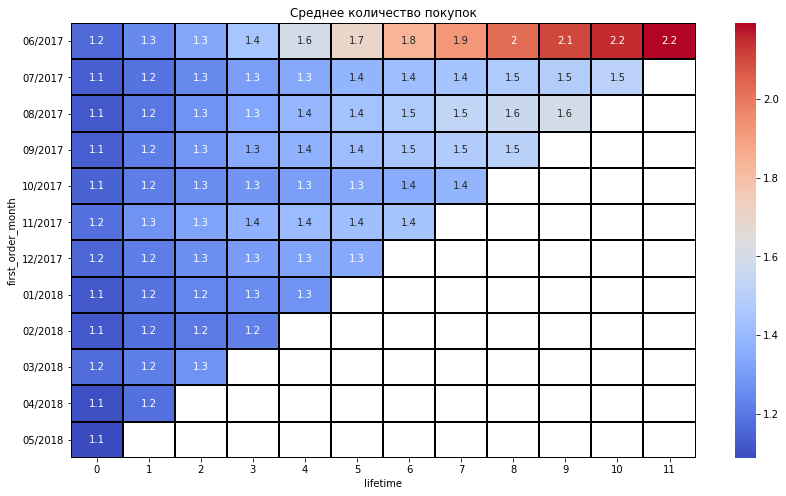

In [85]:
# Построим сводную таблицу и найдем среднее количетсво покупок пользователей
mean_purchase = cohorts_purchases.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'mean_purchase')\
.cumsum(axis=1)

# Приведем индексы к удобному отображению на тепловой карте
mean_purchase.index = mean_purchase.index.strftime("%m/%Y")

# Построим тепловую карту
plt.figure(figsize=(14, 8))
plt.title('Среднее количество покупок')
sns.heatmap(mean_purchase, annot = True, linewidths=1, linecolor='black', cmap= 'coolwarm');

In [40]:
mean = mean_purchase.mean(axis=0)[5]
print('Среднее количество покупок на одного пользователя за шесть месяцeв:', round(mean, 2))

Среднее количество покупок на одного пользователя за шесть месяцeв: 1.43


<div class="alert alert-block alert-info">
Не такой большой показатель, можно задуматься над тем, чтобы предлагать клиентам скидку или подарок после первой покупки
    </div>

<div class="alert alert-block alert-info">
Посчитаем средний чек в каждом месяце и посмотрим меняется ли он со временем и в зависимости от устройства входа.
Для этого необходимо установить первый источник рекламы и устройство первого входа. Первый источник рекламы понадобится нам для расчета LTV, средний чек посчитаем только по устройствам.
    </div>

In [41]:
visits.head()

,device,end_ts,source_id,start_ts,uid,day,week,month,session_time,num_of_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,1
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,1
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,0,1


In [42]:
# Сначала найдем источник и устройство первого входа
first_uid = visits.sort_values(['uid','start_ts']).groupby(['uid'])\
.agg({'source_id':'first', 'device':'first'}).reset_index()

first_uid.head()

,uid,source_id,device
0,11863502262781,3,touch
1,49537067089222,2,touch
2,297729379853735,3,desktop
3,313578113262317,2,desktop
4,325320750514679,5,desktop


In [43]:
orders_device_source = pd.merge(orders, first_uid, on = 'uid', how = 'left').dropna()
orders_device_source['source_id'] = orders_device_source['source_id'].astype(int)
orders_device_source.head()

,buy_ts,revenue,uid,month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,desktop


In [44]:
# Посчитаем средний чек по месяцам
mean_check = orders_device_source.pivot_table(index = 'month', values = 'revenue').reset_index()

# Посчитаем максимальный, минимальный и средний чек
print('Максимальный средний чек:', round(mean_check['revenue'].max(), 2))
print('Минимальный средний чек:', round(mean_check['revenue'].min(), 2))
print('Средний чек:', round(mean_check['revenue'].mean(), 2))
print('--------------------------------------')

# Посчитаем максимальный, минимальный и средний чек с ПК
mean_check_desktop = orders_device_source.query('device == "desktop"')\
.pivot_table(index = 'month', values = 'revenue').reset_index()
print('Максимальный средний чек с ПК:', round(mean_check_desktop['revenue'].max(), 2))
print('Минимальный средний чек с ПК:', round(mean_check_desktop['revenue'].min(), 2))
print('Средний чек с ПК:', round(mean_check_desktop['revenue'].mean(), 2))
print('--------------------------------------')

# Посчитаем максимальный, минимальный и средний чек с телефона
mean_check_touch = orders_device_source.query('device == "touch"')\
.pivot_table(index = 'month', values = 'revenue').reset_index()
print('Максимальный средний чек с телефона:', round(mean_check_touch['revenue'].max(), 2))
print('Минимальный средний чек с телефона:', round(mean_check_touch['revenue'].min(), 2))
print('Средний чек с телефона:', round(mean_check_touch['revenue'].mean(), 2))

Максимальный средний чек: 5.85
Минимальный средний чек: 4.06
Средний чек: 4.96
--------------------------------------
Максимальный средний чек с ПК: 6.38
Минимальный средний чек с ПК: 4.17
Средний чек с ПК: 5.11
--------------------------------------
Максимальный средний чек с телефона: 5.22
Минимальный средний чек с телефона: 3.42
Средний чек с телефона: 4.32


<div class="alert alert-block alert-info">
Средний чек за все месяцы - 4.96.

Средний чек варьируется от 4.06 до 5.85. Разница между минимальным и максимальным значением достаточно ощутима, посмотрим как изменяется средний чек в зависимости от месяца и от устройства.
    </div>

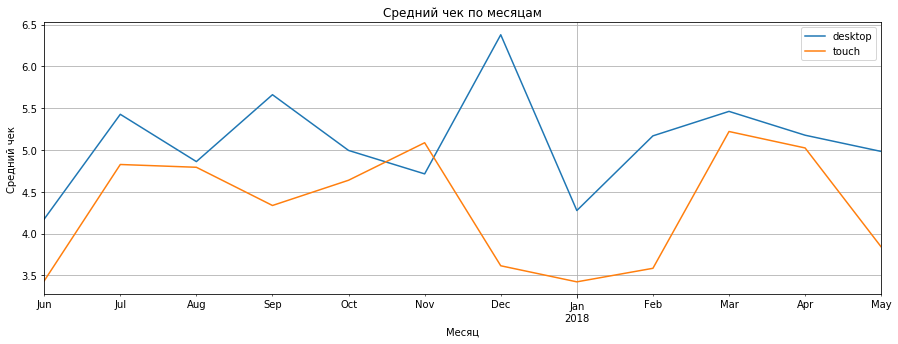

In [45]:
mean_check_devices = orders_device_source.pivot_table(index = 'month', columns = 'device', values = 'revenue')\
.plot(figsize = (15,5), grid = True)
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.title('Средний чек по месяцам')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
Максимальный средний чек у нас в декабре, клиенты Яндекс.Афиши готовят подарки своим друзьям. Средний чек с ПК выше среднего чека с телефона во всех месяцах, кроме ноября. Вероятно это связано с большим количеством покупок ПК
    </div>

<div class="alert alert-block alert-info">
Перейдем к расчету LTV.
    </div>

In [46]:
orders_device_source.head()

,buy_ts,revenue,uid,month,source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,desktop


In [47]:
# Выделим первый месяц покупки
first_month_purchase = orders_device_source.groupby('uid').agg(first_month = ('month', 'min')).reset_index()

# Объединим таблицы
orders_for_ltv_cohorts = pd.merge(orders_device_source, first_month_purchase, on = 'uid')


# Посчитаем время жизни когорты
orders_for_ltv_cohorts['lifetime'] = ((orders_for_ltv_cohorts['month'] - orders_for_ltv_cohorts['first_month'])\
/ np.timedelta64(1,'M')).round().astype(int)

orders_for_ltv_cohorts.head()

,buy_ts,revenue,uid,month,source_id,device,first_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1,desktop,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2,desktop,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2,desktop,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2,desktop,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3,desktop,2017-06-01,0


In [48]:
# Посчитаем размеры когорт
cohort_size_ltv = orders_for_ltv_cohorts.groupby(['source_id', 'first_month'])\
.agg(cohort_size = ('uid', 'nunique')).reset_index()
cohort_size_ltv.head()

,source_id,first_month,cohort_size
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340


In [49]:
# Посчитаем выручку каждой когорты на каждом этапе жизни
revenue_cohorts = orders_for_ltv_cohorts.groupby(['source_id', 'first_month', 'lifetime'])\
.agg(revenue_cohorts = ('revenue', 'sum')).reset_index()
revenue_cohorts.head()

,source_id,first_month,lifetime,revenue_cohorts
0,1,2017-06-01,0,1378.70
1,1,2017-06-01,1,414.98
2,1,2017-06-01,2,419.43
3,1,2017-06-01,3,714.24
4,1,2017-06-01,4,811.20


In [50]:
# Объединим таблицы
orders_for_ltv_source = pd.merge(revenue_cohorts, cohort_size_ltv, on = ['source_id', 'first_month'])
orders_for_ltv_source.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size
0,1,2017-06-01,0,1378.70,190
1,1,2017-06-01,1,414.98,190
2,1,2017-06-01,2,419.43,190
3,1,2017-06-01,3,714.24,190
4,1,2017-06-01,4,811.20,190


In [51]:
# Посчитаем прибыль с каждого пользователя когорты
orders_for_ltv_source['revenue_per_user'] = orders_for_ltv_source['revenue_cohorts']/orders_for_ltv_source['cohort_size']
orders_for_ltv_source.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user
0,1,2017-06-01,0,1378.70,190,7.256316
1,1,2017-06-01,1,414.98,190,2.184105
2,1,2017-06-01,2,419.43,190,2.207526
3,1,2017-06-01,3,714.24,190,3.759158
4,1,2017-06-01,4,811.20,190,4.269474


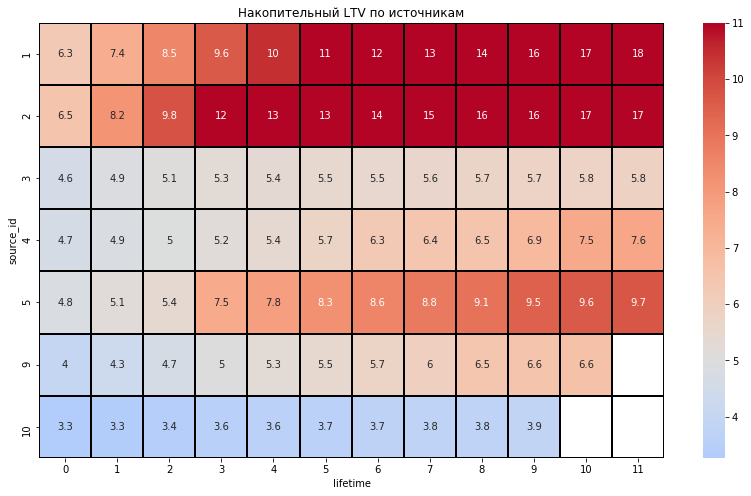

In [86]:
ltv_source = orders_for_ltv_source.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue_per_user')\
.cumsum(axis=1)
plt.figure(figsize=(14, 8))
plt.title('Накопительный LTV по источникам')
sns.heatmap(ltv_source, annot = True, linewidths=1, linecolor='black', vmax=11, center = 5, cmap= 'coolwarm');

<div class="alert alert-block alert-info">
1 и 2 источники рекламы приносят почти в три раза больше выручки с каждого пользователя, относительно других источников. Вероятно это реклама, размещенная на специализированных сайтах - театральных, музейных и т. п.

На эти источники рекламы следует обратить особое внимание, и если это действительно источники со специализированных сайтов, работать над тем, чтобы размещать больше рекламы в таких местах

Посчитаем общий LTV и посмотрим сколько выручки приносят пользователи на каждом этапе жизни когорты.
    </div>

In [53]:
# Посчитаем размеры когорт
cohort_size_ltv_all = orders_for_ltv_cohorts.groupby( 'first_month')\
.agg(cohort_size = ('uid', 'nunique')).reset_index()
cohort_size_ltv_all.head()


,first_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1369
3,2017-09-01,2581
4,2017-10-01,4340


In [54]:
# Посчитаем выручку каждой когорты на каждом этапе жизни
revenue_cohorts_all = orders_for_ltv_cohorts.groupby(['first_month', 'lifetime'])\
.agg(revenue_cohorts = ('revenue', 'sum')).reset_index()
revenue_cohorts_all.head()


,first_month,lifetime,revenue_cohorts
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58


In [55]:
# Объединим таблицы
orders_for_ltv_all = pd.merge(revenue_cohorts_all, cohort_size_ltv_all, on = 'first_month')
orders_for_ltv_all.head()


,first_month,lifetime,revenue_cohorts,cohort_size
0,2017-06-01,0,9557.49,2023
1,2017-06-01,1,981.82,2023
2,2017-06-01,2,885.34,2023
3,2017-06-01,3,1931.30,2023
4,2017-06-01,4,2068.58,2023


In [56]:
# Посчитаем прибыль с каждого пользователя когорты
orders_for_ltv_all['revenue_per_user'] = orders_for_ltv_all['revenue_cohorts']/orders_for_ltv_all['cohort_size']
orders_for_ltv_all.head()

,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531


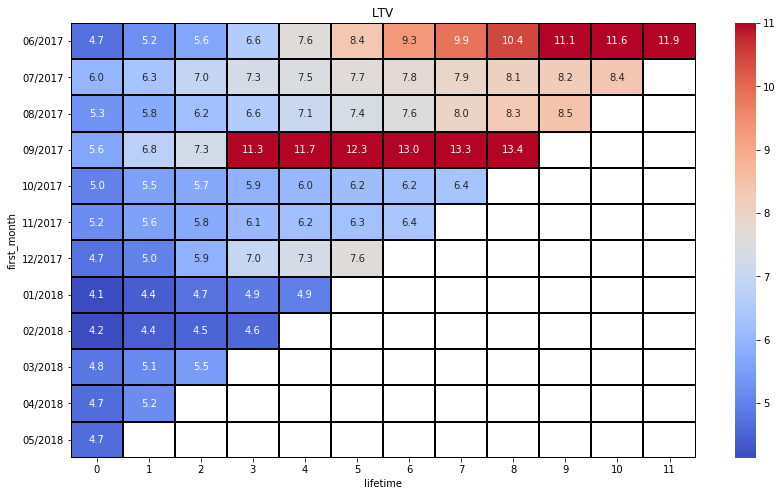

In [87]:
# Составим сводную таблицу
ltv = orders_for_ltv_all.pivot_table(index = 'first_month', columns = 'lifetime',\
                                              values = 'revenue_per_user').cumsum(axis=1)

# Приведем индексы к удобному отображению на тепловой карте
ltv.index = ltv.index.strftime("%m/%Y")

plt.figure(figsize=(14, 8))
plt.title('LTV')
sns.heatmap(ltv, annot = True, linewidths=1, linecolor='black', fmt = '.1f', vmax=11, cmap= 'coolwarm');

In [58]:
m6_cum_ltv = ltv.mean(axis=0)[5]
print('Средний LTV за 6 месяцев после первой покупки:',round(m6_cum_ltv, 2))

Средний LTV за 6 месяцев после первой покупки: 7.97


### Итоги анализа продукта
1. Большинство пользователей совершает покупку при первом же посещении сайта.

2. Каждый покупатель в среднем совершает 1.43 покупки за 6 месяцев.

9. Средний чек с ПК выше среднего чека с телефона.

10. Следует обращать внимание на специализированные источники рекламы, возможно именно они приносят максимальную выручку с пользователей.

11. Каждый пользователь приносит в среднем 7.97 у.е. за шесть месяцев.

## Анализ маркетинга

1) Сколько денег потратили? Всего / на каждый источник / по времени

2) Сколько стоило привлечение одного покупателя из каждого источника?

- Привяжем пользователя к тому источнику из которого была совершена покупка

3) На сколько окупились расходы? (ROMI)

- Здесь мы будем считать насколько окупились расходы на маркетинг - ROMI. Посчитаем эту метрику для каждого источника рекламы и в целом


In [59]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [60]:
# Посчитаем сколько всего потрачено на маркетинг
all_costs = costs['costs'].sum()
print('Всего потрачено на маркетинг:', int(all_costs), 'у.е.')

Всего потрачено на маркетинг: 329131 у.е.


<div class="alert alert-block alert-info">
Сравним затраты на маркетинг с выручкой
    </div>

In [61]:
all_revenue = orders['revenue'].sum()
print('Итоговая валовая прибыль:', int(all_revenue), 'у.е.')

Итоговая валовая прибыль: 252053 у.е.


<div class="alert alert-block alert-info">
Затраты на маркетинг больше, чем получаемая прибыль. Может показаться, что Яндекс.Афиша работает в убыток. Посмотрим, так ли это на самом деле.
    </div>

In [62]:
# Посчитаем затраты на каждый источник рекламы
source_costs = costs.groupby('source_id').agg({'costs':'sum'}).round()
source_costs.sort_values('costs', ascending = False)

,costs
source_id,
3,141322.0
4,61074.0
5,51757.0
2,42806.0
1,20833.0
10,5822.0
9,5517.0


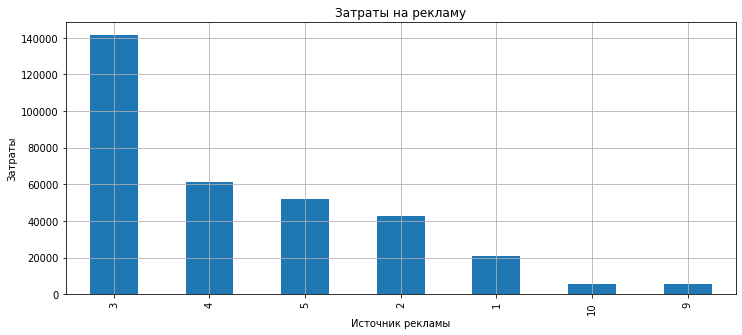

In [63]:
# Представим эти данные на столбчатой диаграмме
source_costs.sort_values('costs', ascending = False).plot(kind = 'bar', figsize=(12, 5), grid = True, legend = False)
plt.xlabel('Источник рекламы')
plt.ylabel('Затраты')
plt.title('Затраты на рекламу')
plt.show()

<div class="alert alert-block alert-info">
Если вспомнить график количества пользователей от источников рекламы, то мы увидим, что из 4-го источника у нас большее количество пользователей, чем из 3-го, а при этом на третий источник тратится более чем в 2 раза больше денег. Также затраты на 4-й источник ненамного выше, чем на 5-й, но пользователей 4-й источник привлекает намного больше. Видно, что затраты на рекламу непропорциональны количеству привлекаемых этой рекламой пользователей.

Посчитаем есть ли зависимость расходов на рекламу от времени. Посчитаем сколько тратили на рекламу каждый месяц
    </div>

In [64]:
# Выделим месяц из даты
costs['month'] = costs['dt'].astype('datetime64[M]')
month_costs = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).round().reset_index()

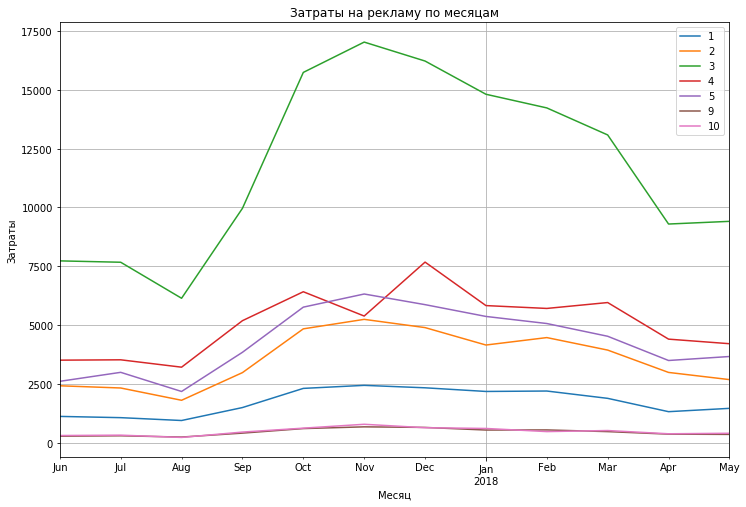

In [65]:
# Представим эти данные на графике
month_costs.pivot = month_costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs')

month_costs.pivot.plot(figsize=(12, 8), grid = True)
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.title('Затраты на рекламу по месяцам')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
Основные затраты на рекламу - три последних месяца года. График практически идентичен графику посещений сайта по месяцам. Больше затрат - больше рекламы - больше посещений.
    </div>

<div class="alert alert-block alert-info">
Посчитаем САС
    </div>

In [66]:
# Посчитаем месячные расходы по каждому источнику
month_costs = costs.groupby(['source_id', 'month']).agg(costs = ('costs', 'sum')).reset_index()
month_costs.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [67]:
# Посмотрим на таблицу с LTV
orders_for_ltv_source.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user
0,1,2017-06-01,0,1378.70,190,7.256316
1,1,2017-06-01,1,414.98,190,2.184105
2,1,2017-06-01,2,419.43,190,2.207526
3,1,2017-06-01,3,714.24,190,3.759158
4,1,2017-06-01,4,811.20,190,4.269474


In [68]:
# Посчитаем месячные расходы по каждому источнику
month_costs = costs.groupby(['source_id', 'month']).agg(costs = ('costs', 'sum')).reset_index()
month_costs.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [69]:
# Добавим в нее данные о затратах
cac_table = pd.merge(orders_for_ltv_source, month_costs,\
                     left_on=['source_id', 'first_month'], right_on=['source_id', 'month'])

cac_table.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs
0,1,2017-06-01,0,1378.70,190,7.256316,2017-06-01,1125.61
1,1,2017-06-01,1,414.98,190,2.184105,2017-06-01,1125.61
2,1,2017-06-01,2,419.43,190,2.207526,2017-06-01,1125.61
3,1,2017-06-01,3,714.24,190,3.759158,2017-06-01,1125.61
4,1,2017-06-01,4,811.20,190,4.269474,2017-06-01,1125.61


In [70]:
cac_table['cac'] = cac_table['costs'] / cac_table['cohort_size']
cac_table.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs,cac
0,1,2017-06-01,0,1378.70,190,7.256316,2017-06-01,1125.61,5.924263
1,1,2017-06-01,1,414.98,190,2.184105,2017-06-01,1125.61,5.924263
2,1,2017-06-01,2,419.43,190,2.207526,2017-06-01,1125.61,5.924263
3,1,2017-06-01,3,714.24,190,3.759158,2017-06-01,1125.61,5.924263
4,1,2017-06-01,4,811.20,190,4.269474,2017-06-01,1125.61,5.924263


In [71]:
# Посчитаем средний САС для каждого источника
cac_for_source = cac_table.groupby('source_id').agg({'cac':'mean'})
cac_for_source.sort_values('cac')

,cac
source_id,
10,5.039289
9,5.059117
4,6.980528
1,7.147620
5,7.171887
2,12.639600
3,14.056894


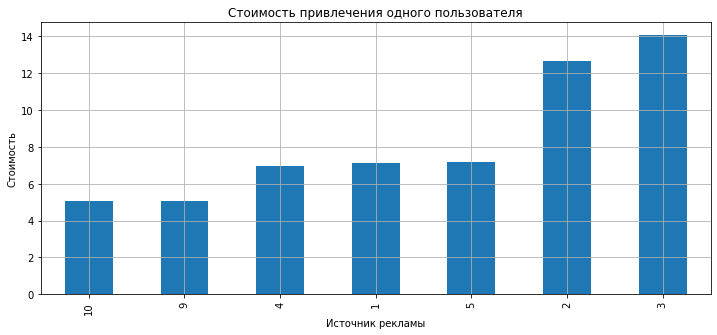

In [72]:
# Представим эти данные на столбчатой диаграмме
cac_for_source.sort_values('cac').plot(kind = 'bar', figsize=(12, 5), grid = True, legend = False)
plt.xlabel('Источник рекламы')
plt.ylabel('Стоимость')
plt.title('Стоимость привлечения одного пользователя')
plt.show()

In [73]:
# Посчитаем среднюю стоимость привлечения одного пользователя
print('Средняя стоимость привлечения одного покупателя:', round(cac_table['cac'].mean(), 2), 'у.е.')

Средняя стоимость привлечения одного покупателя: 8.5 у.е.


<div class="alert alert-block alert-info">
Средняя стоимость привлечения одного покупателя - 8.5 у.е., а средний LTV покупателя - 7.97 у.е. Получается, что покупатель за шесть месяцев практически окупается, а потом должен начинать приносить прибыль
    </div>

<div class="alert alert-block alert-info">
Теперь посчитаем САС в целом, независимо от рекламного источника
    </div>

In [74]:
# Посмотрим на таблицу с LTV
orders_for_ltv_all.head()

,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531


In [75]:
# Посчитаем месячные расходы
month_costs_all = costs.groupby('month').agg(costs = ('costs', 'sum')).reset_index()
month_costs_all.head()

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [76]:
# Добавим в нее данные о затратах
cac_table_all = pd.merge(orders_for_ltv_all, month_costs_all,\
                     left_on='first_month', right_on= 'month')

cac_table_all.head()

,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs
0,2017-06-01,0,9557.49,2023,4.724414,2017-06-01,18015.0
1,2017-06-01,1,981.82,2023,0.485329,2017-06-01,18015.0
2,2017-06-01,2,885.34,2023,0.437637,2017-06-01,18015.0
3,2017-06-01,3,1931.30,2023,0.954671,2017-06-01,18015.0
4,2017-06-01,4,2068.58,2023,1.022531,2017-06-01,18015.0


In [77]:
cac_table_all['cac'] = cac_table_all['costs'] / cac_table_all['cohort_size']
cac_table.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs,cac
0,1,2017-06-01,0,1378.70,190,7.256316,2017-06-01,1125.61,5.924263
1,1,2017-06-01,1,414.98,190,2.184105,2017-06-01,1125.61,5.924263
2,1,2017-06-01,2,419.43,190,2.207526,2017-06-01,1125.61,5.924263
3,1,2017-06-01,3,714.24,190,3.759158,2017-06-01,1125.61,5.924263
4,1,2017-06-01,4,811.20,190,4.269474,2017-06-01,1125.61,5.924263


<div class="alert alert-block alert-info">
Рассчитаем ROMI каждого источника рекламы
    </div>

In [78]:
cac_table['romi'] = cac_table['revenue_per_user'] / cac_table['cac']
cac_table.head()

,source_id,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs,cac,romi
0,1,2017-06-01,0,1378.70,190,7.256316,2017-06-01,1125.61,5.924263,1.224847
1,1,2017-06-01,1,414.98,190,2.184105,2017-06-01,1125.61,5.924263,0.368671
2,1,2017-06-01,2,419.43,190,2.207526,2017-06-01,1125.61,5.924263,0.372625
3,1,2017-06-01,3,714.24,190,3.759158,2017-06-01,1125.61,5.924263,0.634536
4,1,2017-06-01,4,811.20,190,4.269474,2017-06-01,1125.61,5.924263,0.720676


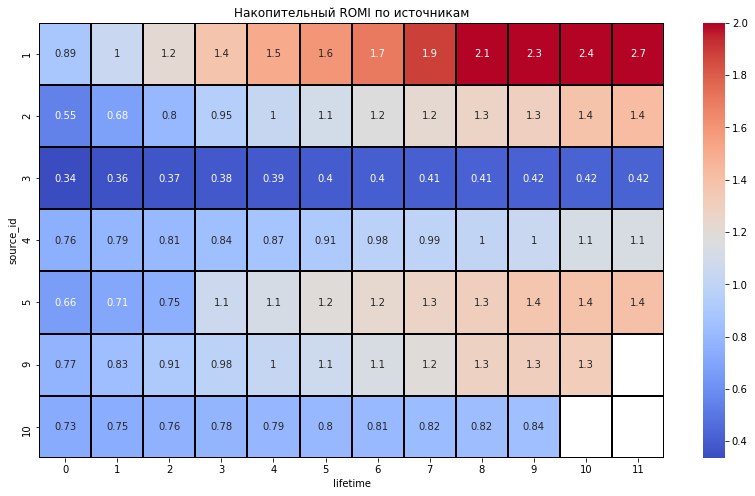

In [88]:
# Построим сводную таблицу
romi_table = cac_table.pivot_table(index = 'source_id', columns = 'lifetime', values = 'romi').cumsum(axis=1)

# Построим тепловую карту
plt.figure(figsize=(14, 8))
plt.title('Накопительный ROMI по источникам')
sns.heatmap(romi_table, annot = True, linewidths=1, linecolor='black', vmax=2, cmap= 'coolwarm');


<div class="alert alert-block alert-info">
Все источники информации, кроме 3-го и 10-го у нас окупаются и начинают приносить прибыль. К тому же на 3-й источник информации тратится в разы больше денег, чем на все остальные. Посмотрим, как это повлияет на общий ROMI
    </div>

In [80]:
cac_table_all['romi'] = cac_table_all['revenue_per_user'] / cac_table_all['cac']
cac_table_all.head()

,first_month,lifetime,revenue_cohorts,cohort_size,revenue_per_user,month,costs,cac,romi
0,2017-06-01,0,9557.49,2023,4.724414,2017-06-01,18015.0,8.905091,0.530530
1,2017-06-01,1,981.82,2023,0.485329,2017-06-01,18015.0,8.905091,0.054500
2,2017-06-01,2,885.34,2023,0.437637,2017-06-01,18015.0,8.905091,0.049145
3,2017-06-01,3,1931.30,2023,0.954671,2017-06-01,18015.0,8.905091,0.107205
4,2017-06-01,4,2068.58,2023,1.022531,2017-06-01,18015.0,8.905091,0.114825


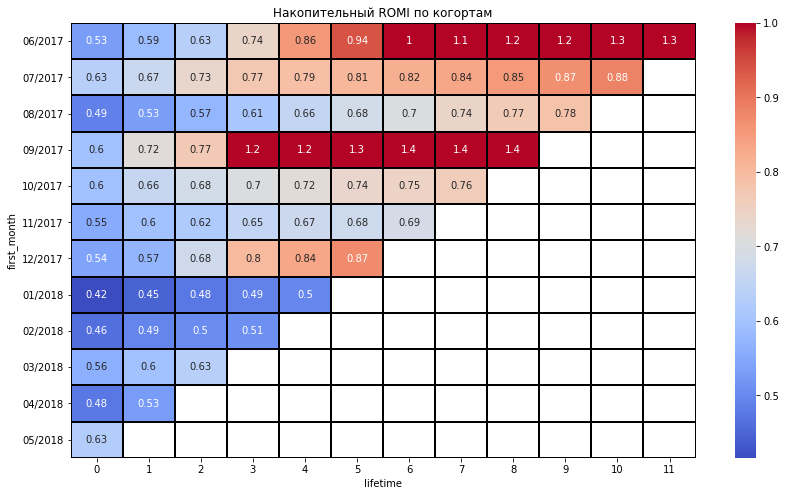

In [89]:
# Построим сводную таблицу
romi_table_all = cac_table_all.pivot_table(index = 'first_month', columns = 'lifetime', values = 'romi').cumsum(axis=1)

# Приведем индексы к удобному отображению на тепловой карте
romi_table_all.index = romi_table_all.index.strftime("%m/%Y")

# Построим тепловую карту
plt.figure(figsize=(14, 8))
plt.title('Накопительный ROMI по когортам')
sns.heatmap(romi_table_all, annot = True, linewidths=1, linecolor='black', vmax=1, cmap= 'coolwarm');


In [90]:
romi_table_all.mean(axis=0)

lifetime
0     0.540809
1     0.581978
2     0.631061
3     0.719731
4     0.782936
5     0.859864
6     0.896805
7     0.969935
8     1.053851
9     0.964460
10    1.094658
11    1.333982
dtype: float64

<div class="alert alert-block alert-info">
Наш продукт должен приносить прибыль. Мы видим, что к 11-му месяцу жизни когорт ROMI уже больше единицы. И пусть до 11-го месяца жизни у нас добрались только две когорты, данный показатель вселяет надежду на успешность продукта.
</div>

# Общий Вывод

1) Яндекс.Афишу, по большей части, используют пользователи ПК. 

2) В зимнее время ресурс популярнее, чем в летнее.

3) У пользователей ПК 2 самых популярных источника рекламы, а у телефонных пользователей - 1. Надо разобраться, возможно это техническая проблема на некоторых моделях телефона (или некоторых версиях телефонных браузеров)

4) Как правило, на одного пользователя приходится одна сессия в день, одного сеанса достаточно для планирования культурного досуга

5) Время средней сессии на ПК и телефоне у нас совпадает - 60 секунд.

6) Пользователи телефонов возвращаются гораздо реже пользователей ПК, нужно подумать над улучшением мобильной версии сайта.

7) Большинство пользователей совершает покупку при первом же посещении сайта.

8) Каждый покупатель в среднем совершает 1.43 покупки за 6 месяцев.

9) Средний чек с ПК выше среднего чека с телефона.

10) Следует обращать внимание на специализированные источники рекламы, возможно именно они приносят максимальную выручку с пользователей.

11) Каждый пользователь приносит в среднем 7.97 у.е. за шесть месяцев.

12) На некоторые источники рекламы тратятся больше денег, хотя пользователей они привлекают меньше.

13) Средняя стоимость привлечения одного покупателя - 8.5 у.е., а средний LTV покупателя - 7.97 у.е. Получается, что покупатель за шесть месяцев практически окупается, а потомс должен начинать приносить прибыль

14) Расчет ROMI вселяет надежду на успешность продукта

Для оптимизации затрат на маркетинг следует отказаться от убыточных рекламных источников - 3-го и 10-го.
